In [49]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community.community_louvain as community_louvain # Richiede il pacchetto python-louvain
from collections import Counter

# Configurazione stile visualizzazioni
sns.set_theme(style="whitegrid", context="notebook", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

print("✓ Librerie importate con successo.")

✓ Librerie importate con successo.


In [50]:
# 1. Caricamento del Grafo
# Carichiamo il grafo salvato in formato GML dal notebook precedente
try:
    G = nx.read_gml('../data/cyber_incidents_graph.gml')
    print(f"✓ Grafo caricato correttamente.")
    print(f"  - Nodi (Paesi): {G.number_of_nodes()}")
    print(f"  - Archi (Attacchi): {G.number_of_edges()}")
    
    # Verifica se il grafo è diretto
    if nx.is_directed(G):
        print("  - Tipo: Diretto")
    else:
        print("  - Tipo: Non diretto")
        
except FileNotFoundError:
    print("❌ Errore: Il file '../data/cyber_incidents_graph.gml' non è stato trovato.")
    print("   Esegui prima il notebook '02_Cyber_Incidents_Graph.ipynb' per generare il grafo.")

✓ Grafo caricato correttamente.
  - Nodi (Paesi): 53
  - Archi (Attacchi): 81
  - Tipo: Diretto


In [51]:
# 2. Calcolo delle Metriche di Centralità
# Ricalcoliamo le metriche per averle disponibili in un DataFrame per l'analisi statistica

print("Calcolo delle metriche di centralità in corso...")

# Degree Centrality (In/Out per grafi diretti)
in_degree = nx.in_degree_centrality(G)
out_degree = nx.out_degree_centrality(G)

# Betweenness Centrality (misura quanto un nodo fa da "ponte")
betweenness = nx.betweenness_centrality(G, weight='weight')

# Closeness Centrality (vicinanza agli altri nodi)
closeness = nx.closeness_centrality(G)

# Eigenvector Centrality (influenza basata sulla connessione a nodi influenti)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
except:
    eigenvector = {node: 0 for node in G.nodes()} # Fallback se non converge

# Creazione DataFrame
metrics_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'In_Degree': [in_degree[n] for n in G.nodes()],
    'Out_Degree': [out_degree[n] for n in G.nodes()],
    'Betweenness': [betweenness[n] for n in G.nodes()],
    'Closeness': [closeness[n] for n in G.nodes()],
    'Eigenvector': [eigenvector[n] for n in G.nodes()]
})

# Aggiungiamo anche il grado grezzo (numero di connessioni)
metrics_df['In_Degree_Raw'] = [G.in_degree(n) for n in G.nodes()]
metrics_df['Out_Degree_Raw'] = [G.out_degree(n) for n in G.nodes()]

print("✓ Metriche calcolate e DataFrame creato.")
display(metrics_df.head())

Calcolo delle metriche di centralità in corso...
✓ Metriche calcolate e DataFrame creato.


,Country,In_Degree,Out_Degree,Betweenness,Closeness,Eigenvector,In_Degree_Raw,Out_Degree_Raw
0,China,0.057692,0.346154,0.110106,0.101171,0.074704,3,18
1,Australia,0.038462,0.000000,0.000000,0.095588,0.019227,2,0
2,Canada,0.038462,0.000000,0.000000,0.098901,0.022124,2,0
3,France,0.019231,0.019231,0.001131,0.079121,0.005978,1,1
4,Germany,0.038462,0.000000,0.000000,0.098901,0.124977,2,0


/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_5341/964531898.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_eigen, x='Eigenvector', y='Country', palette='viridis', ax=axes[1, 0])


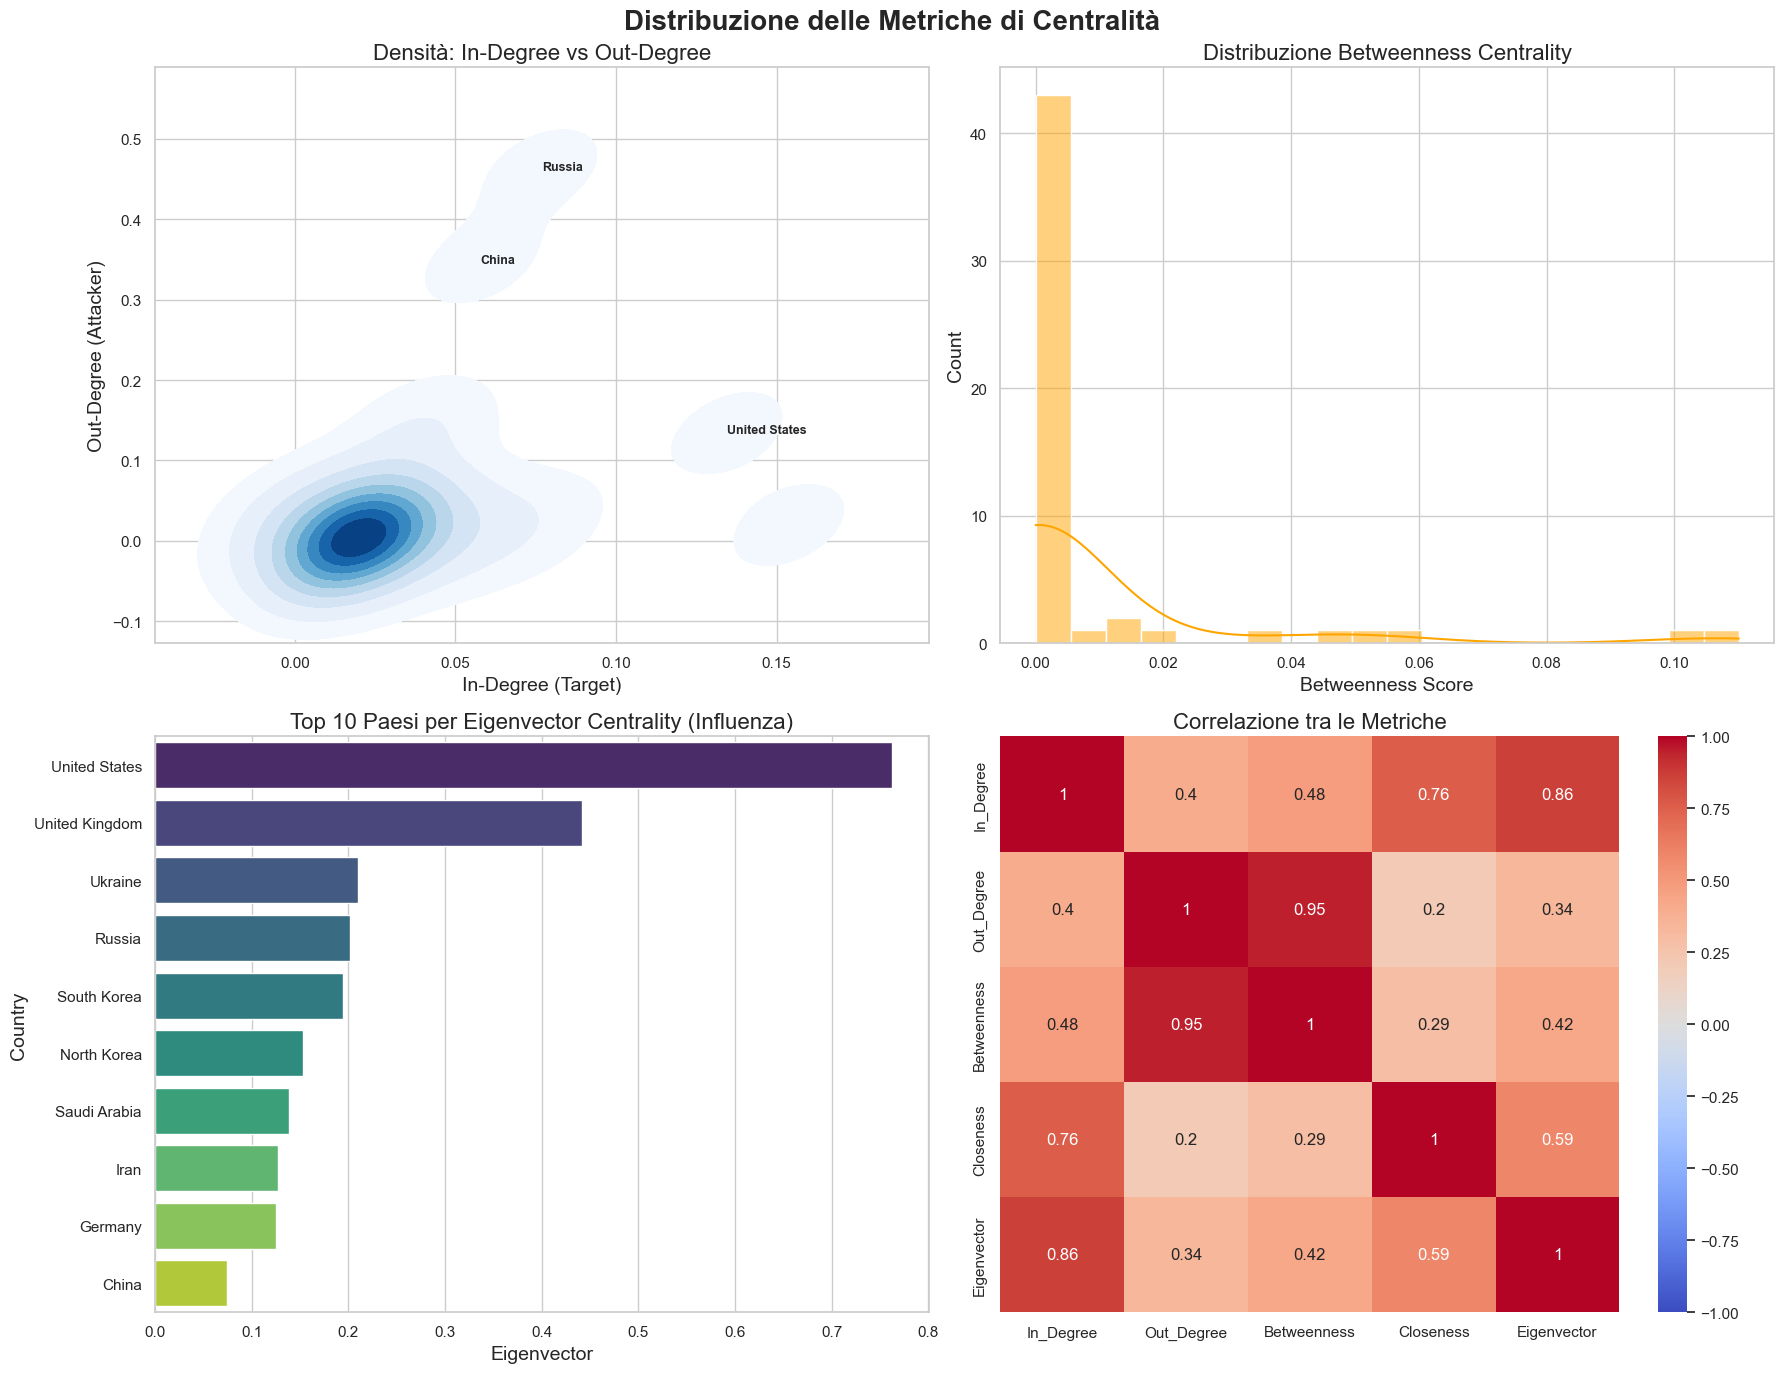

In [52]:
# 3. Visualizzazione Distribuzione Metriche (Seaborn)
# Analizziamo come sono distribuite le metriche tra i vari paesi

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Distribuzione delle Metriche di Centralità', fontsize=20, fontweight='bold')

# Plot 1: In-Degree vs Out-Degree Distribution (KDE)
sns.kdeplot(data=metrics_df, x='In_Degree', y='Out_Degree', fill=True, cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Densità: In-Degree vs Out-Degree')
axes[0, 0].set_xlabel('In-Degree (Target)')
axes[0, 0].set_ylabel('Out-Degree (Attacker)')

# Annotiamo i paesi più estremi
top_active = metrics_df.nlargest(3, 'Out_Degree')
for _, row in top_active.iterrows():
    axes[0, 0].text(row['In_Degree'], row['Out_Degree'], row['Country'], fontsize=9, fontweight='bold')

# Plot 2: Betweenness Distribution (Histogram)
sns.histplot(data=metrics_df, x='Betweenness', bins=20, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribuzione Betweenness Centrality')
axes[0, 1].set_xlabel('Betweenness Score')

# Plot 3: Top 10 Countries by Eigenvector Centrality (Barplot)
top_eigen = metrics_df.nlargest(10, 'Eigenvector')
sns.barplot(data=top_eigen, x='Eigenvector', y='Country', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Paesi per Eigenvector Centrality (Influenza)')

# Plot 4: Correlation Matrix Heatmap
corr = metrics_df[['In_Degree', 'Out_Degree', 'Betweenness', 'Closeness', 'Eigenvector']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlazione tra le Metriche')

plt.tight_layout()
plt.show()

Numero totale di clique trovati: 54
Dimensione del clique più grande: 4
Numero di clique di dimensione massima: 4


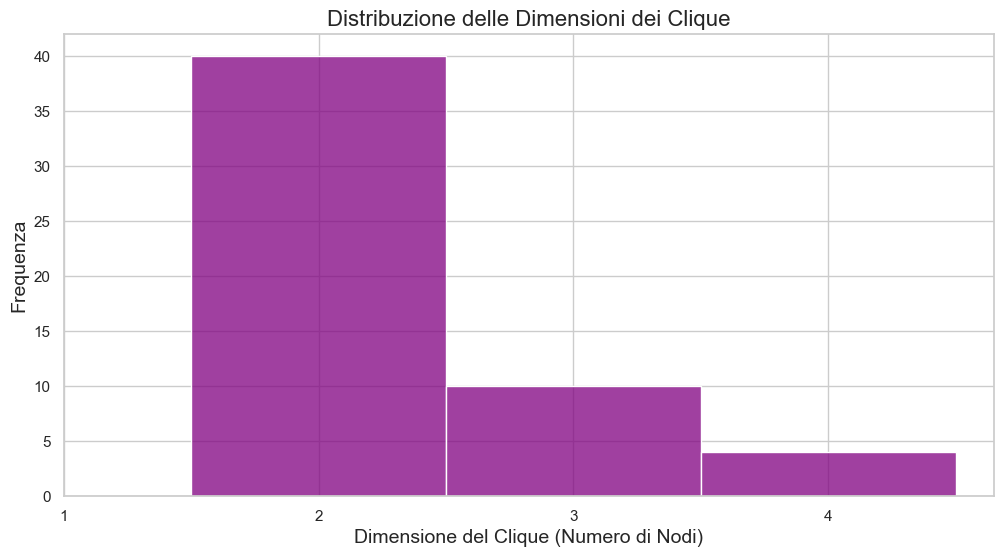

Paesi nel clique più grande:
['North Korea', 'China', 'United States', 'United Kingdom']


In [53]:
# 4. Analisi dei Clique
# Un clique è un sottografo in cui tutti i nodi sono connessi tra loro.
# Per questa analisi, convertiamo il grafo in non orientato.

G_undirected = G.to_undirected()
cliques = list(nx.find_cliques(G_undirected))

# Calcolo dimensioni dei clique
clique_sizes = [len(c) for c in cliques]
max_clique_size = max(clique_sizes)
max_cliques = [c for c in cliques if len(c) == max_clique_size]

print(f"Numero totale di clique trovati: {len(cliques)}")
print(f"Dimensione del clique più grande: {max_clique_size}")
print(f"Numero di clique di dimensione massima: {len(max_cliques)}")

# Visualizzazione distribuzione dimensioni clique
plt.figure(figsize=(12, 6))
sns.histplot(clique_sizes, bins=range(1, max_clique_size + 2), discrete=True, color='purple')
plt.title('Distribuzione delle Dimensioni dei Clique')
plt.xlabel('Dimensione del Clique (Numero di Nodi)')
plt.ylabel('Frequenza')
plt.xticks(range(1, max_clique_size + 1))
plt.show()

print("Paesi nel clique più grande:")
print(max_cliques[0])

Numero di community rilevate: 5

Dimensioni delle community (Top 5):
Community
1    20
0    14
3    10
2     6
4     3
Name: count, dtype: int64


/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_5341/1454948721.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=community_counts.index, y=community_counts.values, palette='tab10')


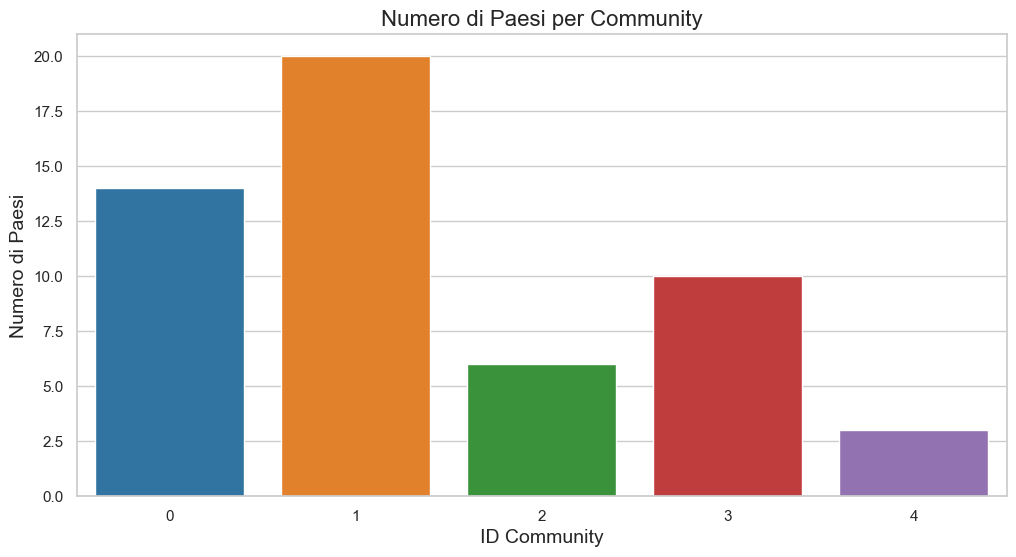

In [54]:
# 5. Rilevamento delle Community (Louvain Algorithm)
# Identifichiamo gruppi di paesi che interagiscono più frequentemente tra loro.

# L'algoritmo di Louvain lavora meglio su grafi non orientati per la modularità standard
partition = community_louvain.best_partition(G_undirected, weight='weight')

# Aggiungiamo l'informazione della community al DataFrame delle metriche
metrics_df['Community'] = metrics_df['Country'].map(partition)

# Statistiche delle community
community_counts = metrics_df['Community'].value_counts()
num_communities = len(community_counts)

print(f"Numero di community rilevate: {num_communities}")
print("\nDimensioni delle community (Top 5):")
print(community_counts.head())

# Visualizzazione composizione community
plt.figure(figsize=(12, 6))
sns.barplot(x=community_counts.index, y=community_counts.values, palette='tab10')
plt.title('Numero di Paesi per Community')
plt.xlabel('ID Community')
plt.ylabel('Numero di Paesi')
plt.show()

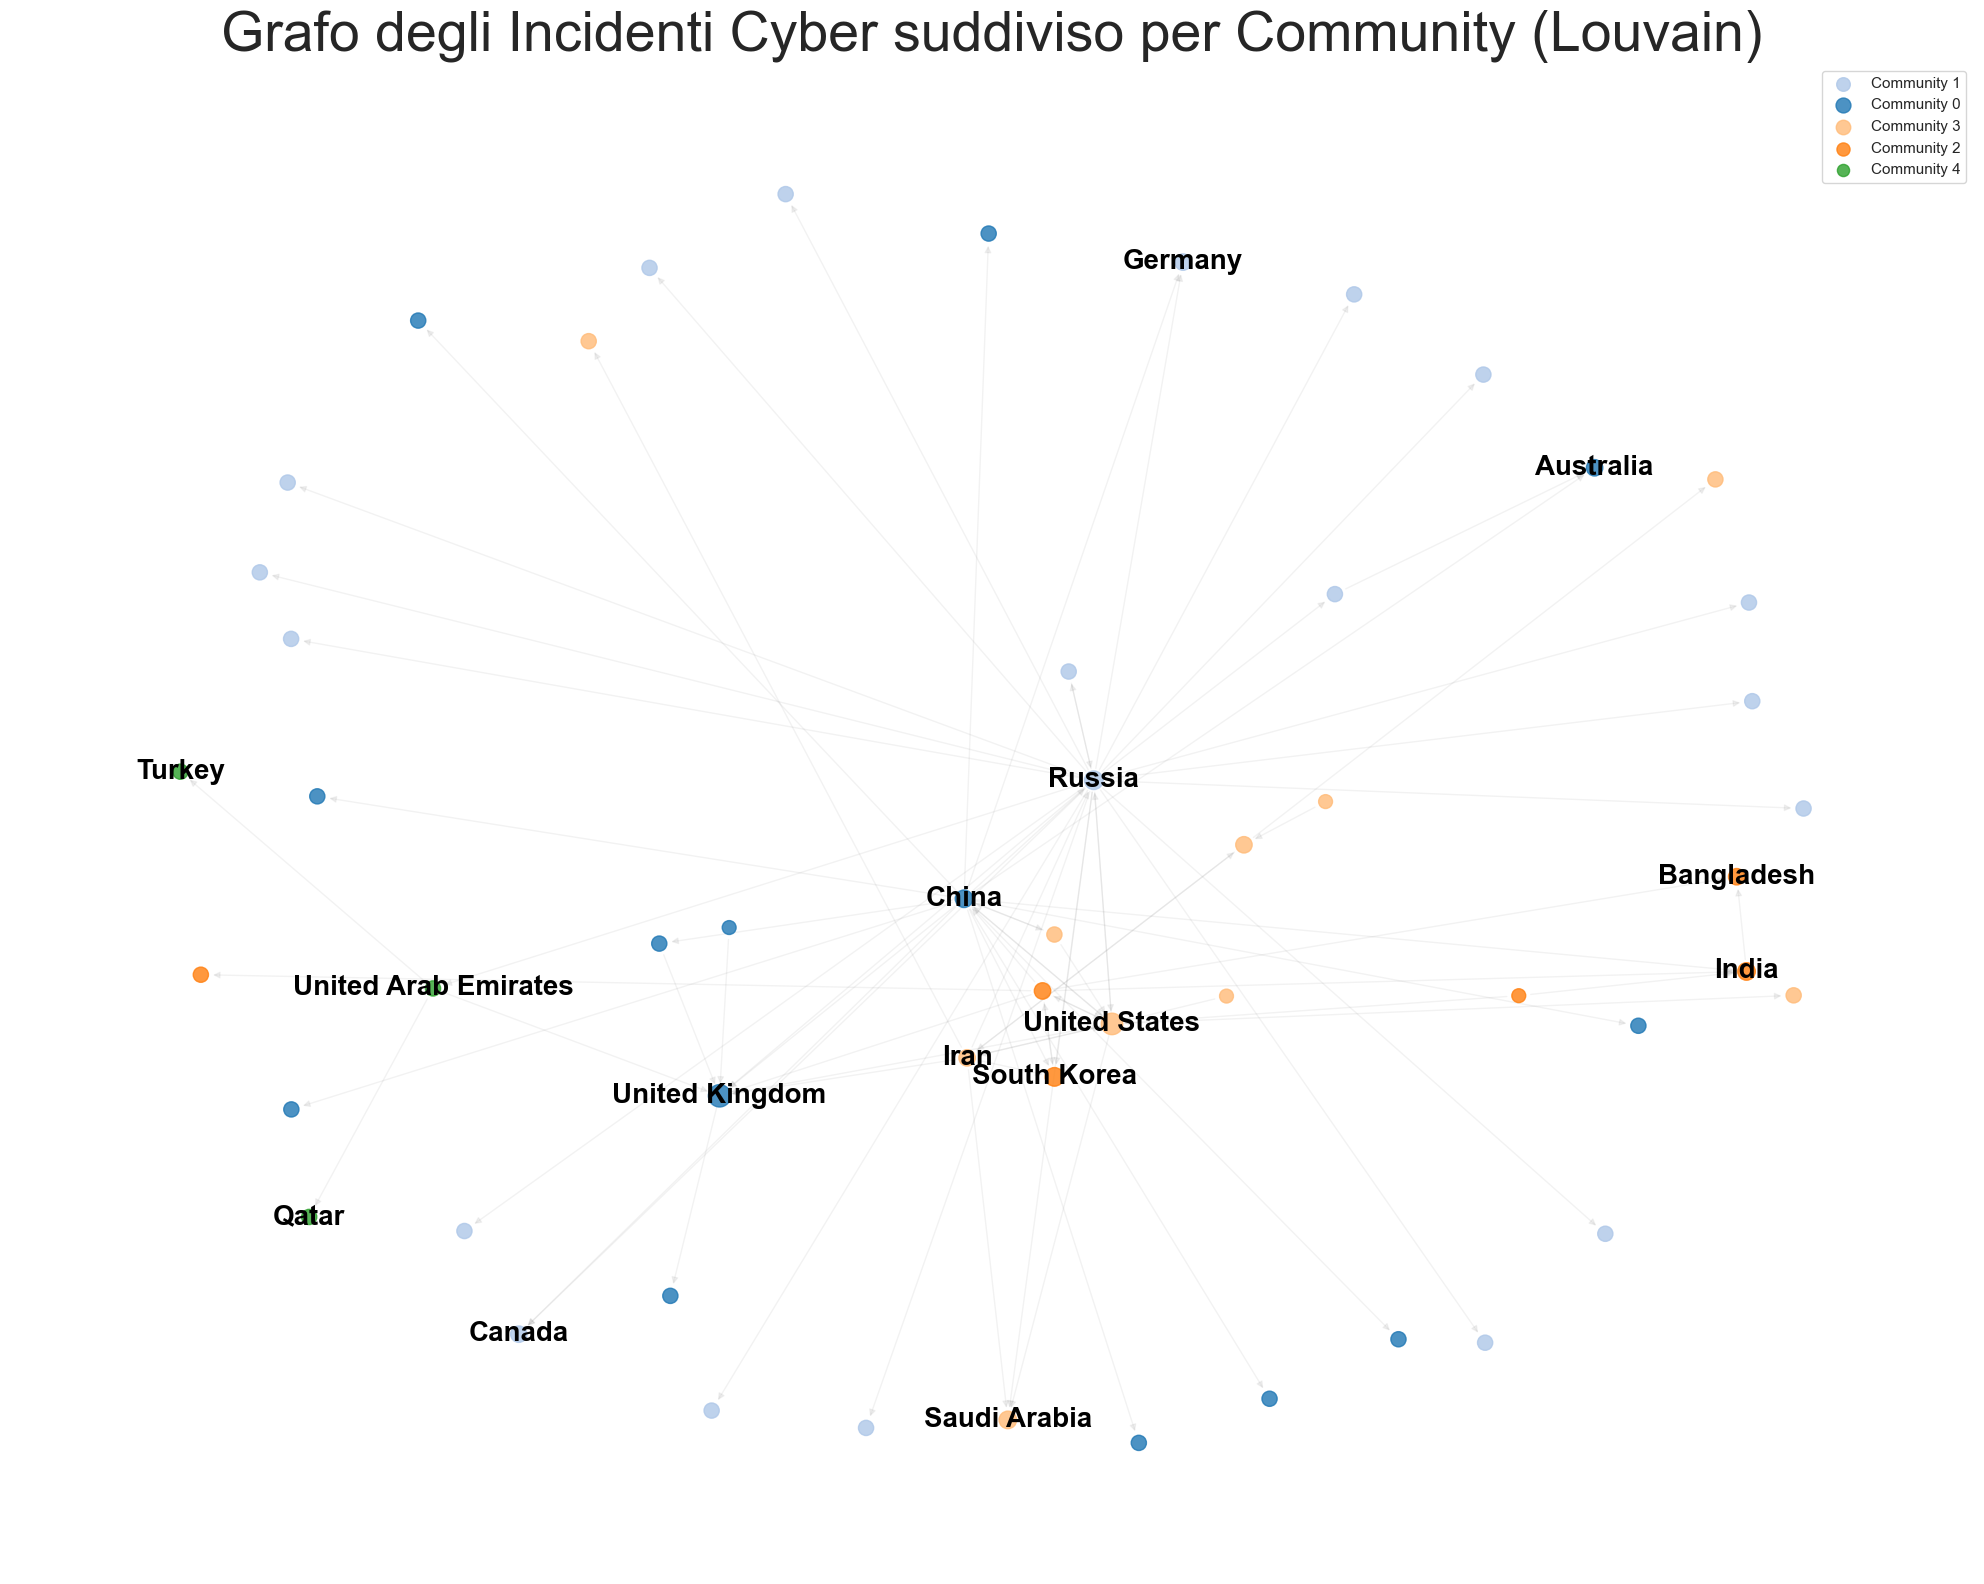

In [55]:
# 6. Visualizzazione del Grafo con Community
# Disegniamo il grafo colorando i nodi in base alla loro community di appartenenza

plt.figure(figsize=(20, 16))

# Layout
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Colori per le community
cmap = plt.get_cmap('tab20')

# Disegno nodi
for com_id in community_counts.index:
    nodes_in_com = [n for n, c in partition.items() if c == com_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_com, 
                           node_size=100 + metrics_df[metrics_df['Community']==com_id]['In_Degree_Raw']*20,
                           node_color=[cmap(com_id)], 
                           label=f"Community {com_id}", alpha=0.8)

# Disegno archi (più sottili e trasparenti per pulizia)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Etichette per i nodi più importanti (es. top 3 per degree in ogni community grande)
labels_to_draw = {}
for com_id in community_counts.head(5).index:
    top_nodes = metrics_df[metrics_df['Community'] == com_id].nlargest(3, 'In_Degree_Raw')['Country']
    for node in top_nodes:
        labels_to_draw[node] = node

nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=20, font_weight='bold')

plt.title('Grafo degli Incidenti Cyber suddiviso per Community (Louvain)', fontsize=40)
plt.legend(markerscale=0.8, loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()

Analisi della Community più grande (ID: 1)
Nodi: 20
Archi interni: 20
Densità interna: 0.0526


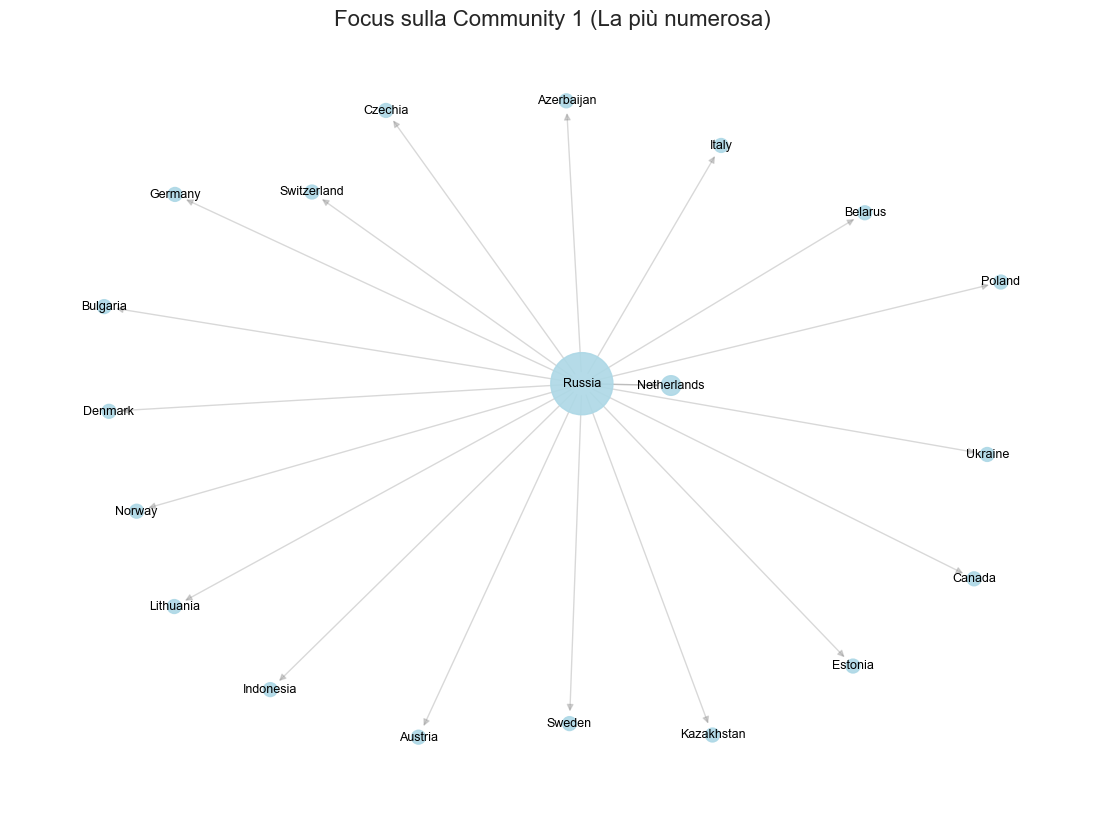

In [56]:
# 7. Analisi Approfondita della Community Principale
# Estraiamo e visualizziamo solo la community più numerosa per vedere i dettagli

largest_com_id = community_counts.idxmax()
nodes_largest_com = [n for n, c in partition.items() if c == largest_com_id]
subgraph = G.subgraph(nodes_largest_com)

print(f"Analisi della Community più grande (ID: {largest_com_id})")
print(f"Nodi: {len(nodes_largest_com)}")
print(f"Archi interni: {subgraph.number_of_edges()}")
print(f"Densità interna: {nx.density(subgraph):.4f}")

plt.figure(figsize=(14, 10))
pos_sub = nx.spring_layout(subgraph, k=0.5, seed=42)

# Dimensioni nodi basate sul degree interno al sottografo
node_sizes_sub = [v * 100 for v in dict(subgraph.degree()).values()]

nx.draw_networkx_nodes(subgraph, pos_sub, node_size=node_sizes_sub, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos_sub, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos_sub, font_size=9)

plt.title(f'Focus sulla Community {largest_com_id} (La più numerosa)', fontsize=16)
plt.axis('off')
plt.show()